In [ ]:
# Hacky way to schedule. Here I'm setting these to sleep until the gpus should be free.
# At the end of the notebooks  os._exit(00) will kill the kernel freeing the gpu. 
#                          Hours to wait
# import time; time.sleep( 6 * (60*60))

# G only KEGG based network architecture

> 

In [ ]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

# import hilbertcurve
# from hilbertcurve.hilbertcurve import HilbertCurve

from EnvDL.core import * # includes remove_matching_files
from EnvDL.dna import *
from EnvDL.dlfn import *

from tqdm import tqdm

In [ ]:
from graphviz import Digraph
import torchviz

In [ ]:
cache_path = '../nbs_artifacts/01.25_g2fc_demo_G_ACGT_graph/'
ensure_dir_path_exists(dir_path = cache_path)

## Load data

In [ ]:
load_from = '../nbs_artifacts/01.03_g2fc_prep_matrices/'
# phno = pd.read_csv(load_from+'phno.csv')
phno_geno = pd.read_csv(load_from+'phno_geno.csv')
phno = phno_geno

obs_geno_lookup = np.load(load_from+'obs_geno_lookup.npy') # Phno_Idx	Geno_Idx	Is_Phno_Idx
YMat = np.load(load_from+'YMat.npy')
# GMat = np.load(load_from+'GMat.npy')
# ACGT_OneHot = np.load(load_from+'ACGT_OneHot.npy')
# ACGT = np.load(load_from+'ACGT.npy')
# ACGT_hilb = np.load(load_from+'ACGT_hilb.npy')
# SMat = np.load(load_from+'SMat3.npy')
# WMat = np.load(load_from+'WMat3.npy')
# MMat = np.load(load_from+'MMat3.npy')

In [ ]:
# dataloader_batch_size = 8 #16 #64
# run_epochs = 200

use_gpu_num = 0

# Imports --------------------------------------------------------------------
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
if use_gpu_num in [0, 1]: 
    torch.cuda.set_device(use_gpu_num)
print(f"Using {device} device")

Using cuda device


## Simple case: Building a Neural Net from an arbitrary graph

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 58254.22it/s]


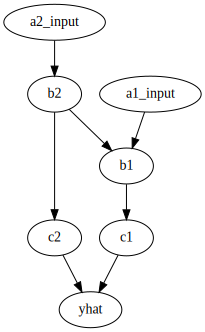

In [ ]:
# the simplest possible way to do this:
# input1 (a1) -> b1  -> c1 \
#             /             -> yhat
# input1 (a2) -> b2  -> c2 /

example_dict = {
    'yhat':['c1', 'c2'], # <-  extra node that makes a prediction from the top level nodes in the graph
      'c1':['b1'],
      'c2':['b2'],
      'b1':['a1_input', 'b2'],
      'b2':['a2_input']}

dot = Digraph()
for key in tqdm(example_dict.keys()):
    dot.node(key)
    for value in example_dict[key]:
        # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
        dot.edge(value, key)    
dot

In [ ]:
# start by finding the top level -- all those keys which are theselves not values
# helper function to get all keys and all value from a dict. Useful for when keys don't have unique values.
def find_uniq_keys_values(input_dict):
    all_keys = list(input_dict.keys())
    all_values = []
    for e in all_keys:
        all_values.extend(input_dict[e])
    all_values = list(set(all_values))

    return({'all_keys': all_keys,
           'all_values': all_values})

res = find_uniq_keys_values(input_dict = example_dict)
all_keys = res['all_keys']
all_values = res['all_values']

# use the keys to find the input/outputs of the graph
output_nodes = [e for e in all_keys if e not in all_values]
input_nodes = [e for e in all_values if e not in all_keys]

(output_nodes, input_nodes)

(['yhat'], ['a1_input', 'a2_input'])

### Find order that nodes in the graph should be called to have all dependencies run when they are called.

In [ ]:
temp = example_dict.copy()

# find the dependancies for run order from many dependancies to none
# wrapper function to find the nodes that aren't any other nodes dependancies.
def find_top_nodes(all_key_value_dict):
    return([e for e in all_key_value_dict['all_keys'] if e not in all_key_value_dict['all_values']])
# wrapper function to find the input nodes. They don't occur in the keys and thus won't be added to the list otherwise.
# another way to do this would have been to 
def find_input_nodes(all_key_value_dict):
    return([e for e in all_key_value_dict['all_values'] if e not in all_key_value_dict['all_keys']])

no_dependants = find_input_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))

# first pass. Same as the output nodes identified above
dependancy_order = []

# Then iterate
for ith in range(100):
    top_nodes = find_top_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
    if top_nodes == []:
        break
    else:
        dependancy_order += top_nodes    
        # remove nodes from the graph that are at the 'top' level and haven't already been removed
        for key in [e for e in dependancy_order if e in temp.keys()]:
             temp.pop(key)

        
    print(dependancy_order)

# finally add in the inputs.        
# dependancy_order += no_dependants

['yhat']
['yhat', 'c1', 'c2']
['yhat', 'c1', 'c2', 'b1']
['yhat', 'c1', 'c2', 'b1', 'b2']


In [ ]:
# reverse to get the order that the nodes should be called
dependancy_order.reverse()
dependancy_order

['b2', 'b1', 'c2', 'c1', 'yhat']

### Set up output tensor

In [ ]:
y_true = np.random.uniform(-1, 1, 10).reshape(-1, 1) # (b, 3)
y_true = torch.from_numpy(y_true)

In [ ]:
y_true

tensor([[-0.4400],
        [ 0.6021],
        [ 0.7336],
        [-0.1710],
        [ 0.0410],
        [-0.5253],
        [ 0.1147],
        [ 0.1865],
        [ 0.7155],
        [-0.9879]], dtype=torch.float64)

### Set up dict of input tensors

In [ ]:
no_dependants

['a1_input', 'a2_input']

In [ ]:
a1_input = torch.from_numpy(np.random.uniform(-1, 1, 20).reshape(-1, 2)) # (b, 2))
a2_input = torch.from_numpy(np.random.uniform(-1, 1, 30).reshape(-1, 3)) # (b, 3))

In [ ]:
input_tensor_dict = {}
for e in no_dependants:
    input_tensor_dict[e] = eval(e).to(torch.float) # I don't know if this is a safe thing to do.
    
input_tensor_dict

{'a1_input': tensor([[ 0.6516, -0.3675],
         [ 0.8425, -0.6563],
         [ 0.8546, -0.7918],
         [-0.9604,  0.0513],
         [-0.1055, -0.5864],
         [-0.8895, -0.9669],
         [-0.0554,  0.3060],
         [-0.7997,  0.2590],
         [ 0.3880, -0.4160],
         [-0.2452, -0.2638]]),
 'a2_input': tensor([[-0.7071, -0.1955, -0.5123],
         [ 0.7443,  0.8725, -0.4426],
         [ 0.8381,  0.7178,  0.9532],
         [ 0.7953,  0.4527, -0.7931],
         [ 0.5579, -0.1045,  0.7178],
         [ 0.9739,  0.5910, -0.0946],
         [-0.6446,  0.2593, -0.1805],
         [-0.2814,  0.2892,  0.4718],
         [ 0.4413, -0.2004, -0.2869],
         [-0.6192,  0.8066, -0.1776]])}

### Figure out expected input/output shapes

_==NOTE! This assumes only dense connections!==_

In [ ]:
# now let's figure out the size that each node should expect as an input.
# For now I assume that each node will have the same number of outputs as its inputs. 
# ==NOTE== if instead each node had a fixed output (e.g. 10 channels) then all non-inputs could be replaced with this value
example_dict_input_size = example_dict.copy()

In [ ]:
# add in channel number
for e in no_dependants:
    example_dict_input_size[e] = list(input_tensor_dict[e].shape)[1] # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)

In [ ]:
# walk through dependancy order
for e in dependancy_order:
    # get the channel number for each dependency and sum to get the input channels expected
    res = sum([example_dict_input_size[key] for key in example_dict_input_size[e]])

    # overwrite with the value
    example_dict_input_size[e] = res

example_dict_input_size

{'yhat': 8, 'c1': 5, 'c2': 3, 'b1': 5, 'b2': 3, 'a1_input': 2, 'a2_input': 3}

In [ ]:
# Now make an output dict
example_dict_output_size = example_dict_input_size.copy()
example_dict_output_size['yhat'] = 1
example_dict_output_size

{'yhat': 1, 'c1': 5, 'c2': 3, 'b1': 5, 'b2': 3, 'a1_input': 2, 'a2_input': 3}

In [ ]:
example_dict.keys()
# example_dict_input_size

dict_keys(['yhat', 'c1', 'c2', 'b1', 'b2'])

### Set up DataSet

Now we have

- A dictionary with the connections: `example_dict`
- The expected input sizes for each node: `example_dict_input_size`
- A dictionary with the input tensors: `input_tensor_dict`
- A list of the input tensors' names: `no_dependants` 
- A list with the order that each module should be called: `dependancy_order`

In [ ]:
class ListDataset(Dataset): # for any G containing matix with many (phno) to one (geno)
    def __init__(self, 
                 y, 
                 x_list,
                 transform = None, target_transform = None,
                 use_gpu_num = 0,
                 device = 'cuda',
                 **kwargs 
                ):
        self.device = device
        self.y = y 
        self.x_list = x_list,
        self.transform = transform
        self.target_transform = target_transform    
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        y_idx =self.y[idx]
        x_idx =[x[idx] for x in self.x_list[0]] # must be the 0th entry because it's in a tuple
        
        if self.target_transform:
            y_idx = self.transform(y_idx)
            x_idx = [self.transform(x) for x in x_idx]
            
        return y_idx, x_idx
    

In [ ]:
training_dataloader = DataLoader(ListDataset(
        y = y_true,
        x_list = [input_tensor_dict[key] for key in input_tensor_dict.keys()],
        use_gpu_num = 0,
        device = 'cuda',
    ),
    batch_size = 5,
    shuffle = True
)
next(iter(training_dataloader))

[tensor([[ 0.1147],
         [ 0.6021],
         [ 0.1865],
         [ 0.7336],
         [-0.5253]], dtype=torch.float64),
 [tensor([[-0.0554,  0.3060],
          [ 0.8425, -0.6563],
          [-0.7997,  0.2590],
          [ 0.8546, -0.7918],
          [-0.8895, -0.9669]]),
  tensor([[-0.6446,  0.2593, -0.1805],
          [ 0.7443,  0.8725, -0.4426],
          [-0.2814,  0.2892,  0.4718],
          [ 0.8381,  0.7178,  0.9532],
          [ 0.9739,  0.5910, -0.0946]])]]

### Set up NeuralNetwork

In [ ]:
# input_tensor_names = list(input_tensor_dict.keys())
# input_tensor_names

In [ ]:
# first pass is by hand.
class NeuralNetwork(nn.Module):
    def __init__(self, 
                 example_dict, # contains the node (excluding input tensors)
                 example_dict_input_size, # contains the input sizes (including the tensors)
                 example_dict_output_size,
                 input_tensor_names,
                 dependancy_order
                ):
        super(NeuralNetwork, self).__init__()
        def Linear_block(in_size, out_size, drop_pr):
            block = nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.ReLU(),
                nn.Dropout(drop_pr))
            return(block)   
        
        self.nn_dict = {}
        # iterate through the input dictionary and add a linear block for each node (key) included 
        for key in example_dict.keys():
            self.nn_dict[key] = Linear_block(in_size=example_dict_input_size[key], 
                                             out_size=example_dict_output_size[key], 
                                             drop_pr=0)
        # things for get_input_node in forward to work.
        self.example_dict = example_dict
        self.input_tensor_names = input_tensor_names
        self.dependancy_order = dependancy_order
        
        self.input_tensor_lookup = dict(zip(input_tensor_names, 
                                            [i for i in range(len(input_tensor_names))]))
        self.result_list = []
        self.result_list_lookup = {}

    def forward(self, x):
        # Note: x will be a list. input_tensor_lookup will contain the name: list index pairs.
        # I use a dict instead of a list comprehension here because there could be an arbitrarily
        # large number of inputs in the list. 
        def get_input_node(self, input_node, get_x):    
            if input_node in self.input_tensor_names:
                return(get_x[self.input_tensor_lookup[input_node]])
            else:
                return(self.result_list[self.result_list_lookup[input_node]])
            
        for key in self.dependancy_order:
            input_nodes = self.example_dict[key]
            
            if key not in self.result_list_lookup.keys():
                # I realllllly hope these are being copied by reference...
                # must be first before growing result_list
                self.result_list_lookup[key] = len(self.result_list_lookup)
                self.result_list += [self.nn_dict[key](torch.concat(
                    [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
                    1))]
            else:
                # Note! here I'm saving the tensor without wrapping it in a list.
                self.result_list[self.result_list_lookup[key]] = self.nn_dict[key](torch.concat(
                    [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
                    1))
                
        return self.result_list[self.result_list_lookup['yhat']]

model = NeuralNetwork(example_dict = example_dict, 
                      example_dict_input_size = example_dict_input_size,
                      example_dict_output_size = example_dict_output_size,
                      input_tensor_names = list(input_tensor_dict.keys()),
                      dependancy_order = dependancy_order)

In [ ]:
yhat = model(next(iter(training_dataloader))[1])
yhat

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<ReluBackward0>)

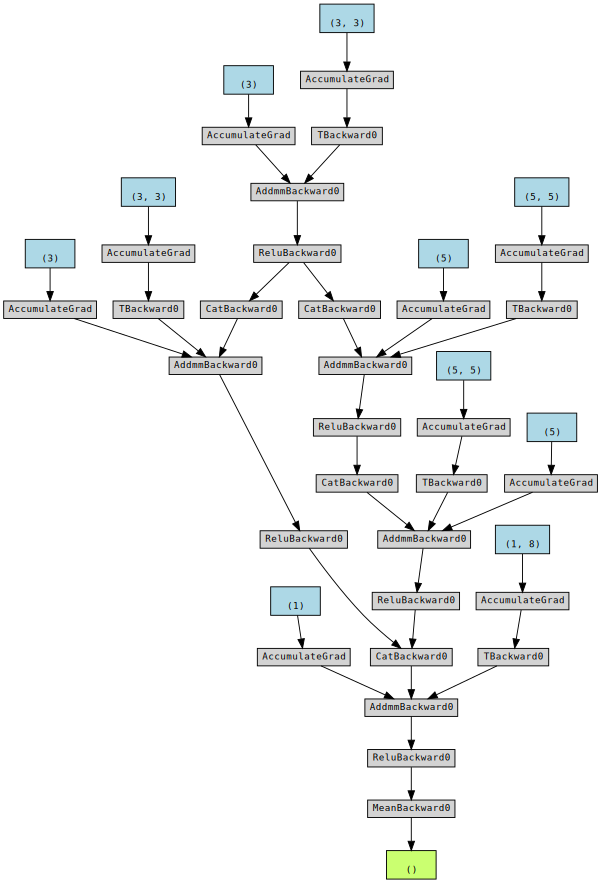

In [ ]:
torchviz.make_dot(yhat.mean(), params=dict(model.named_parameters()))

## KEGG graph 

In [ ]:
# import pickle as pkl
# with open('../data/zma/kegg/kegg_gene_entries.pkl', 'rb') as handle:
#     parsed_kegg_gene_entries = pkl.load(handle)

# Testing using the cleaned up version in '../nbs_artifacts/01.05_g2fc_demo_model/'
load_from = '../nbs_artifacts/01.05_g2fc_demo_model/'
parsed_kegg_gene_entries = get_cached_result(load_from+'filtered_kegg_gene_entries.pkl')

ACGT_gene_slice_list = get_cached_result(load_from+'ACGT_gene_slice_list.pkl')

In [ ]:
assert len(ACGT_gene_slice_list) == len(parsed_kegg_gene_entries)

In [ ]:
# Restrict to only those with pathway
kegg_gene_brite = [e for e in parsed_kegg_gene_entries if 'BRITE' in e.keys()]

In [ ]:
# also require to have a non-empty path
kegg_gene_brite = [e for e in kegg_gene_brite if not e['BRITE']['BRITE_PATHS'] == []]

In [ ]:
print('Retaining '+ str(round(len(kegg_gene_brite)/len(parsed_kegg_gene_entries), 4)*100)+'%, '+str(len(kegg_gene_brite)
     )+'/'+str(len(parsed_kegg_gene_entries)
     )+' Entries'
     )

Retaining 43.53%, 6067/13939 Entries


In [ ]:
kegg_gene_brite[1]['BRITE']['BRITE_PATHS']

[['KEGG Orthology (KO) [BR:zma00001]',
  '09100 Metabolism',
  '09102 Energy metabolism',
  '00190 Oxidative phosphorylation',
  '100383860'],
 ['Enzymes [BR:zma01000]',
  '7. Translocases',
  '7.1  Catalysing the translocation of hydrons',
  '7.1.2  Linked to the hydrolysis of a nucleoside triphosphate',
  '7.1.2.1  P-type H+-exporting transporter',
  '100383860']]

### Tiny 2 gene version of the network:

In [ ]:
len(kegg_gene_brite)

6067

In [ ]:
"""
The goal here is to have a dict with each node and a list of it's children. 
For example, the graph
a--b--d
 |-c--e
Would be parsed into     
{'a':['b', 'c'],
 'b':['d'],
 'c':['e']}
"""
kegg_connections = {}

# for all genes in list
for i in tqdm(range(2)): # <------------------------- only using 2 inputs genes
# for i in tqdm(range(len(kegg_gene_brite))):    
    temp = kegg_gene_brite[i]['BRITE']['BRITE_PATHS']
    # clean up to make sure that there are no ":" characters. These can mess up graphviz
    temp = [[temp[j][i].replace(':', '-') for i in range(len(temp[j])) ] for j in range(len(temp))]
    # all paths through graph associated with a gene
    for j in range(len(temp)):
        # steps of the path through the graph
        for k in range(len(temp[j])-1):
            # if this is a new key, add it and add the k+1 entry as it's child
            if temp[j][k] not in kegg_connections.keys():
                kegg_connections[temp[j][k]] = [temp[j][k+1]]
            else: 
                # Check to see if there's a new child to add   
                if temp[j][k+1] not in kegg_connections[temp[j][k]]:
                    # add it.
                    kegg_connections[temp[j][k]].extend([temp[j][k+1]])

# kegg_connections

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 30393.51it/s]


In [ ]:
# add yhat node to the graph
temp_values = []
for key in kegg_connections.keys():
    temp_values += kegg_connections[key]

kegg_connections['y_hat'] = [key for key in kegg_connections.keys() if key not in temp_values]

100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 57614.07it/s]


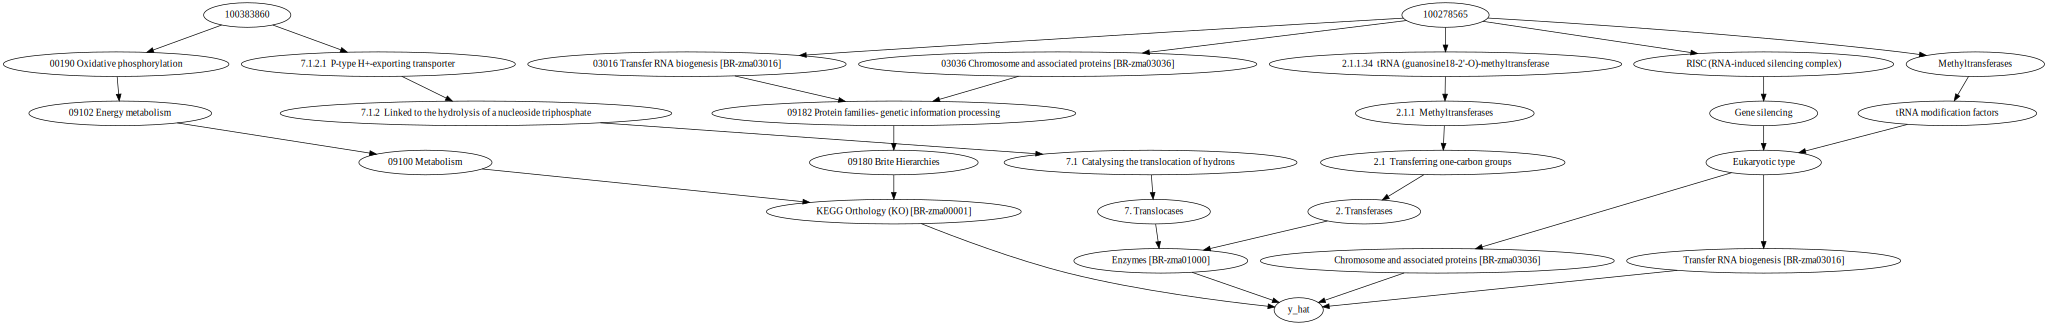

In [ ]:
# This is too big to render in full

dot = Digraph()
for key in tqdm(kegg_connections.keys()):
    dot.node(key)
    for value in kegg_connections[key]:
        # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
        dot.edge(value, key)    
    
dot

Version with the node names masked for size 

100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 159843.90it/s]


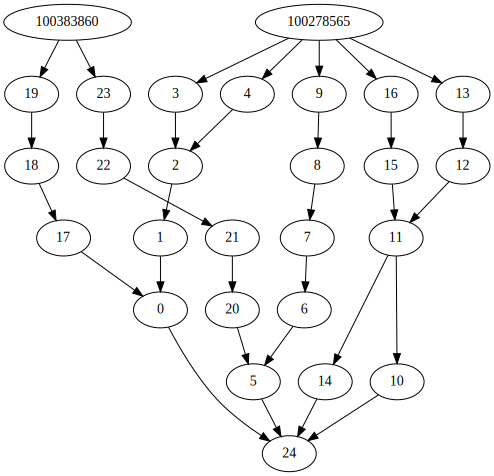

In [ ]:
name_to_num_dict = dict(zip(list(kegg_connections.keys()),
                            [str(i) for i in range(len(list(kegg_connections.keys())))]))

temp = {}
for key in kegg_connections.keys():
    temp[name_to_num_dict[key]] = [name_to_num_dict[e] if e in name_to_num_dict.keys() else e for e in kegg_connections[key]]

dot = Digraph()
for key in tqdm(temp.keys()):
    dot.node(key)
    for value in temp[key]:
        # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
        dot.edge(value, key)    

# dot.render(directory=cache_path, view=True) 
dot

### Setup the DataLoader

In [ ]:
# start by finding the top level -- all those keys which are theselves not values
res = find_uniq_keys_values(input_dict = kegg_connections)
all_keys = res['all_keys']
all_values = res['all_values']

# use the keys to find the input/outputs of the graph
output_nodes = [e for e in all_keys if e not in all_values]
input_nodes = [e for e in all_values if e not in all_keys]

(output_nodes, input_nodes)

(['y_hat'], ['100278565', '100383860'])

In [ ]:
# find the dependancies for run order from many dependancies to none
temp = kegg_connections.copy()

no_dependants = find_input_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
# first pass. Same as the output nodes identified above
dependancy_order = []
# Then iterate
for ith in range(100): #TODO <- this should be set as a input parameter
    top_nodes = find_top_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
    if top_nodes == []:
        break
    else:
        dependancy_order += top_nodes    
        # remove nodes from the graph that are at the 'top' level and haven't already been removed
        for key in [e for e in dependancy_order if e in temp.keys()]:
             temp.pop(key)

# dependancy_order

In [ ]:
# reverse to get the order that the nodes should be called
dependancy_order.reverse()
dependancy_order

['7.1.2.1  P-type H+-exporting transporter',
 "2.1.1.34  tRNA (guanosine18-2'-O)-methyltransferase",
 '7.1.2  Linked to the hydrolysis of a nucleoside triphosphate',
 '00190 Oxidative phosphorylation',
 'RISC (RNA-induced silencing complex)',
 'Methyltransferases',
 '2.1.1  Methyltransferases',
 '03036 Chromosome and associated proteins [BR-zma03036]',
 '03016 Transfer RNA biogenesis [BR-zma03016]',
 '7.1  Catalysing the translocation of hydrons',
 '09102 Energy metabolism',
 'Gene silencing',
 'tRNA modification factors',
 '2.1  Transferring one-carbon groups',
 '09182 Protein families- genetic information processing',
 '7. Translocases',
 '09100 Metabolism',
 'Eukaryotic type',
 '2. Transferases',
 '09180 Brite Hierarchies',
 'Chromosome and associated proteins [BR-zma03036]',
 'Transfer RNA biogenesis [BR-zma03016]',
 'Enzymes [BR-zma01000]',
 'KEGG Orthology (KO) [BR-zma00001]',
 'y_hat']

-### Set up dict of input tensors

In [ ]:
# build a dict to go from the node names in `no_dependants` to the list index in `ACGT_gene_slice_list`
brite_node_to_list_idx_dict = {}
for i in tqdm(range(len(kegg_gene_brite))):
    brite_node_to_list_idx_dict[str(kegg_gene_brite[i]['BRITE']['BRITE_PATHS'][0][-1])] = i

100%|██████████████████████████████████████████████████████████████████████████| 6067/6067 [00:00<00:00, 1432575.71it/s]


In [ ]:
input_tensor_dict = {}
for e in no_dependants:
    input_tensor_dict[e] = ACGT_gene_slice_list[brite_node_to_list_idx_dict[e]]
    
# input_tensor_dict

-### Figure out expected input/output shapes

_==NOTE! This assumes only dense connections!==_

In [ ]:
# This could be replaced by a sort of "distance from output" measure
default_output_size = 5
output_size_dict = dict(zip(dependancy_order, 
                        [default_output_size for i in range(len(dependancy_order))]))
output_size_dict['y_hat'] = 1 
output_size_dict

{'7.1.2.1  P-type H+-exporting transporter': 5,
 "2.1.1.34  tRNA (guanosine18-2'-O)-methyltransferase": 5,
 '7.1.2  Linked to the hydrolysis of a nucleoside triphosphate': 5,
 '00190 Oxidative phosphorylation': 5,
 'RISC (RNA-induced silencing complex)': 5,
 'Methyltransferases': 5,
 '2.1.1  Methyltransferases': 5,
 '03036 Chromosome and associated proteins [BR-zma03036]': 5,
 '03016 Transfer RNA biogenesis [BR-zma03016]': 5,
 '7.1  Catalysing the translocation of hydrons': 5,
 '09102 Energy metabolism': 5,
 'Gene silencing': 5,
 'tRNA modification factors': 5,
 '2.1  Transferring one-carbon groups': 5,
 '09182 Protein families- genetic information processing': 5,
 '7. Translocases': 5,
 '09100 Metabolism': 5,
 'Eukaryotic type': 5,
 '2. Transferases': 5,
 '09180 Brite Hierarchies': 5,
 'Chromosome and associated proteins [BR-zma03036]': 5,
 'Transfer RNA biogenesis [BR-zma03016]': 5,
 'Enzymes [BR-zma01000]': 5,
 'KEGG Orthology (KO) [BR-zma00001]': 5,
 'y_hat': 1}

In [ ]:
# BACKUP VERSION -----------------------------------------------------------------------------------
# input_size_dict = kegg_connections.copy()

# # use the expected output sizes from `output_size_dict` to fill in the non-data sizes
# for e in tqdm(input_size_dict.keys()):
#     # overwrite named connections with the output size of those connections
#     # if the entry is in no_dependants it's data so it's size needs to be grabbed from the input_tensor_dict
#     input_size_dict[e] = [
#         list(input_tensor_dict[ee].shape)[-1] # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)
#         if ee in no_dependants
#         else output_size_dict[ee] for ee in input_size_dict[e]]

# # Now walk over entries and overwrite with the sum of the inputs
# for e in tqdm(input_size_dict.keys()):
#     input_size_dict[e] = np.sum(input_size_dict[e])

# CHANNEL AWARE VERSION -----------------------------------------------------------------------------------
input_size_dict = kegg_connections.copy()

# use the expected output sizes from `output_size_dict` to fill in the non-data sizes
tensor_ndim = len(input_tensor_dict[list(input_tensor_dict.keys())[0]].shape)
for e in tqdm(input_size_dict.keys()):
    # overwrite named connections with the output size of those connections
    # if the entry is in no_dependants it's data so it's size needs to be grabbed from the input_tensor_dict
    
    # is there no channel dim? (major/minor allele)
    if 2 == tensor_ndim:
        input_size_dict[e] = [
            list(input_tensor_dict[ee].shape)[-1] # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)
            if ee in no_dependants
            else output_size_dict[ee] for ee in input_size_dict[e]]
    elif 3 == tensor_ndim: # There is a channel dim
        input_size_dict[e] = [
            (list(input_tensor_dict[ee].shape)[1]*list(input_tensor_dict[ee].shape)[2]) # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)  
            if ee in no_dependants
            else output_size_dict[ee] for ee in input_size_dict[e]]

# Now walk over entries and overwrite with the sum of the inputs
for e in tqdm(input_size_dict.keys()):
    input_size_dict[e] = np.sum(input_size_dict[e])

100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166176.86it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48343.75it/s]


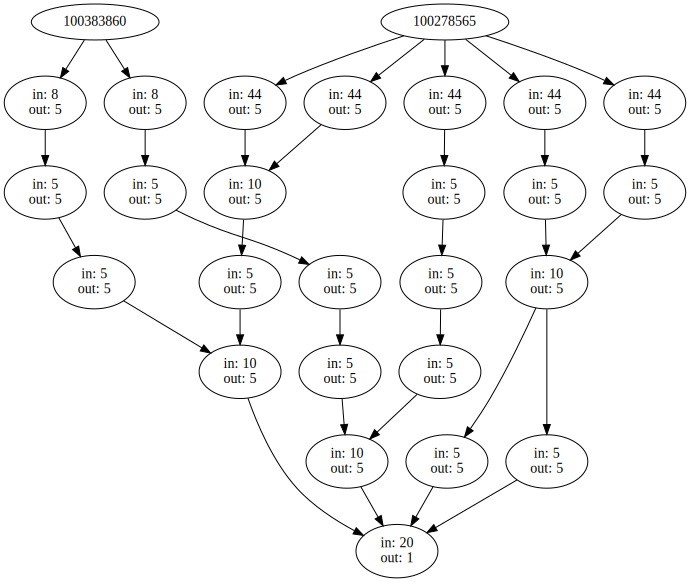

In [ ]:
dot = Digraph()
for key in tqdm(kegg_connections.keys()):
    key_label = 'in: '+str(input_size_dict[key])+'\nout: '+str(output_size_dict[key])
    dot.node(key, key_label)
    for value in kegg_connections[key]:
        # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
        dot.edge(value, key)    
    
dot

### Set up DataSet

Now we have

- A dictionary with the connections: `example_dict`
- The expected input sizes for each node: `example_dict_input_size`
- A dictionary with the input tensors: `input_tensor_dict`
- A list of the input tensors' names: `no_dependants` 
- A list with the order that each module should be called: `dependancy_order`

In [ ]:
class ListDataset(Dataset): # for any G containing matix with many (phno) to one (geno)
    def __init__(self, 
                 y, 
                 x_list,
                 obs_idxs, # this is a list of the indexes used. It allows us to pass in smaller 
                           # tensors and then get the right genotype
                 obs_geno_lookup,
                 transform = None, target_transform = None,
                 use_gpu_num = 0,
                 device = 'cuda',
                 **kwargs 
                ):
        self.device = device
        self.y = y 
        self.x_list = x_list
        self.obs_idxs = obs_idxs
        self.obs_geno_lookup = obs_geno_lookup
        self.transform = transform
        self.target_transform = target_transform    
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        y_idx =self.y[idx]
        
        idx_geno = obs_geno_lookup[self.obs_idxs[idx], 1]
#         print(idx)
#         print(self.obs_idxs[idx])
#         print(obs_geno_lookup[self.obs_idxs[idx], 1])
# #         print([x.shape for x in self.x_list[0]])
#         print([e.shape for e in self.x_list])
#         print()
#         x_idx =[x[idx_geno, ] for x in self.x_list[0]] # must be the 0th entry because it's in a tuple
        x_idx =[x[idx_geno, ] for x in self.x_list] 
        
        if self.target_transform:
            y_idx = self.transform(y_idx)
            x_idx = [self.transform(x) for x in x_idx]
            
        return y_idx, x_idx
    

In [ ]:
[e.shape for e in x_list_temp]

[torch.Size([4926, 4, 11]), torch.Size([4926, 4, 2])]

[torch.Size([5, 4, 11]), torch.Size([5, 4, 2])]

To have a fair test of whether the model is working, I want to ensure there is information to learn in the dataset. To this end I'm using just two genotypes.

In [ ]:
# These are the genotypes with the most observations. 
pd.DataFrame(zip(
    [i for i in range(4898)],
    [len(obs_geno_lookup[obs_geno_lookup[:, 1] == i, 0]) for i in range(4898)]
)).sort_values(1).tail()

,0,1
153,153,534
389,389,539
151,151,563
154,154,604
170,170,611


In [ ]:
idxs_two_genotypes = list(obs_geno_lookup[obs_geno_lookup[:, 1] == 154, 0]
                   )+list(obs_geno_lookup[obs_geno_lookup[:, 1] == 170, 0])
np.random.shuffle(idxs_two_genotypes)

In [ ]:
test_idx = idxs_two_genotypes[0:round(len(idxs_two_genotypes)*.1)]
train_idx = idxs_two_genotypes[round(len(idxs_two_genotypes)*.1):]

In [ ]:
# they do have a different mean
[np.mean(YMat[i]) for i in [test_idx, train_idx]]

[10.381543189652486, 10.749772639664256]

In [ ]:
# obs_geno_lookup # Phno_Idx	Geno_Idx	Is_Phno_Idx

In [ ]:
# input_tensor_dict['100383860'].shape

In [ ]:
# x_list_temp = [torch.from_numpy(input_tensor_dict[key]).to(torch.float) for key in input_tensor_dict.keys()]
# [e.shape for e in x_list_temp]
# y_temp = torch.from_numpy(YMat[0:4926,]).to(torch.float)#[:, None]
# y_temp.shape

# training_dataloader = DataLoader(ListDataset(
#         y = y_temp,
#         x_list = x_list_temp,
#         use_gpu_num = 0,
#         device = 'cuda',
#     ),
#     batch_size = 5,
#     shuffle = True
# )

In [ ]:
x_list_temp = [torch.from_numpy(input_tensor_dict[key]).to(torch.float) for key in input_tensor_dict.keys()]
[e.shape for e in x_list_temp]
y_temp = torch.from_numpy(YMat).to(torch.float)#[:, None]
y_temp.shape

#FIXME tiny set to test out on cpu
training_dataloader = DataLoader(ListDataset(
        y = y_temp[train_idx][:, None],
        x_list = [e for e in x_list_temp],
        obs_idxs = train_idx, 
        obs_geno_lookup = obs_geno_lookup, 
        use_gpu_num = 0,
        device = 'cuda',
    ),
    batch_size = 5,
    shuffle = True
)

testing_dataloader = DataLoader(ListDataset(
        y = y_temp[test_idx][:, None],
        x_list = [e for e in x_list_temp],
        obs_idxs = test_idx, 
        obs_geno_lookup = obs_geno_lookup,
        use_gpu_num = 0,
        device = 'cuda',
    ),
    batch_size = 5,
    shuffle = True
)



# next(iter(training_dataloader))[1]

In [ ]:
[e.shape for e in next(iter(training_dataloader))[1]]

[torch.Size([5, 4, 11]), torch.Size([5, 4, 2])]

### Set up NeuralNetwork

In [ ]:
# # first pass is by hand.
# class NeuralNetwork(nn.Module):
#     def __init__(self, 
#                  example_dict, # contains the node (excluding input tensors)
#                  example_dict_input_size, # contains the input sizes (including the tensors)
#                  example_dict_output_size,
#                  input_tensor_names,
#                  dependancy_order
#                 ):
#         super(NeuralNetwork, self).__init__()
#         def Linear_block(in_size, out_size, drop_pr):
#             block = nn.Sequential(
#                 nn.Linear(in_size, out_size),
#                 nn.ReLU(),
#                 nn.Dropout(drop_pr))
#             return(block)   
        
#         self.nn_dict = {}
#         # iterate through the input dictionary and add a linear block for each node (key) included 
#         for key in example_dict.keys():
#             self.nn_dict[key] = Linear_block(in_size=example_dict_input_size[key], 
#                                              out_size=example_dict_output_size[key], 
#                                              drop_pr=0)
#         # things for get_input_node in forward to work.
#         self.example_dict = example_dict
#         self.input_tensor_names = input_tensor_names
#         self.dependancy_order = dependancy_order
        
#         self.input_tensor_lookup = dict(zip(input_tensor_names, 
#                                             [i for i in range(len(input_tensor_names))]))
#         self.result_list = []
#         self.result_list_lookup = {}

#     def forward(self, x):
#         # Note: x will be a list. input_tensor_lookup will contain the name: list index pairs.
#         # I use a dict instead of a list comprehension here because there could be an arbitrarily
#         # large number of inputs in the list. 
#         def get_input_node(self, input_node, get_x):    
#             if input_node in self.input_tensor_names:
#                 return(get_x[self.input_tensor_lookup[input_node]])
#             else:
#                 return(self.result_list[self.result_list_lookup[input_node]])
            
#         for key in self.dependancy_order:
#             input_nodes = self.example_dict[key]
            
#             if key not in self.result_list_lookup.keys():
#                 # I realllllly hope these are being copied by reference...
#                 # must be first before growing result_list
#                 self.result_list_lookup[key] = len(self.result_list_lookup)
                    
#                 self.result_list += [self.nn_dict[key](torch.concat(
#                     [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
#                     -1))] # Concat based on the last dim


#             else:
#                 print('b')
#                 # Note! here I'm saving the tensor without wrapping it in a list.
#                 self.result_list[self.result_list_lookup[key]] = self.nn_dict[key](torch.concat(
#                     [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
#                     -1))
                
#         return self.result_list[self.result_list_lookup['y_hat']]
    
# model = NeuralNetwork(example_dict = kegg_connections, 
#                       example_dict_input_size = input_size_dict,
#                       example_dict_output_size = output_size_dict,
#                       input_tensor_names = list(input_tensor_dict.keys()),
#                       dependancy_order = dependancy_order)    


# yhat = model(next(iter(training_dataloader))[1])
# yhat

In [ ]:
# [e for e in model.parameters()]

In [ ]:
# [e for e in model.nn_dict['KEGG Orthology (KO) [BR-zma00001]'].parameters()]

In [ ]:
# [e for e in model.nn_dict['09180 Brite Hierarchies'].parameters()]

In [ ]:
# torchviz.make_dot(
#     yhat.mean(), 
#                   params=dict(model.named_parameters()), 
# #                   show_attrs=True, 
# #                   show_saved=True
#                  )

In [ ]:
# obs_geno_lookup # Phno_Idx	Geno_Idx	Is_Phno_Idx
# YMat

In [ ]:
# kegg_connections
# input_size_dict
# output_size_dict
# list(input_tensor_dict.keys())
dependancy_order

['7.1.2.1  P-type H+-exporting transporter',
 "2.1.1.34  tRNA (guanosine18-2'-O)-methyltransferase",
 '7.1.2  Linked to the hydrolysis of a nucleoside triphosphate',
 '00190 Oxidative phosphorylation',
 'RISC (RNA-induced silencing complex)',
 'Methyltransferases',
 '2.1.1  Methyltransferases',
 '03036 Chromosome and associated proteins [BR-zma03036]',
 '03016 Transfer RNA biogenesis [BR-zma03016]',
 '7.1  Catalysing the translocation of hydrons',
 '09102 Energy metabolism',
 'Gene silencing',
 'tRNA modification factors',
 '2.1  Transferring one-carbon groups',
 '09182 Protein families- genetic information processing',
 '7. Translocases',
 '09100 Metabolism',
 'Eukaryotic type',
 '2. Transferases',
 '09180 Brite Hierarchies',
 'Chromosome and associated proteins [BR-zma03036]',
 'Transfer RNA biogenesis [BR-zma03016]',
 'Enzymes [BR-zma01000]',
 'KEGG Orthology (KO) [BR-zma00001]',
 'y_hat']

In [ ]:
# first pass is by hand.
class NeuralNetwork(nn.Module):
    def __init__(self, 
                 example_dict, # contains the node (excluding input tensors)
                 example_dict_input_size, # contains the input sizes (including the tensors)
                 example_dict_output_size,
                 input_tensor_names,
                 dependancy_order
                ):
        super(NeuralNetwork, self).__init__()
        def Linear_block(in_size, out_size, drop_pr):
            block = nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.ReLU(),
                nn.Dropout(drop_pr))
            return(block)   
        
        
        # fill in the list in dependancy order. 
        layer_list = []
        for key in dependancy_order:
            # I think that input nodes need to flatten the input and expect 4*length inputs
            # TODO only flatten the input layers
            layer_list += [nn.Sequential(
                nn.Flatten(),
                Linear_block(in_size=example_dict_input_size[key], 
                             out_size=example_dict_output_size[key], 
                             drop_pr=0))
                          ]

        self.nn_layer_list = nn.ModuleList(layer_list)
                    
        
        # things for get_input_node in forward to work.
        self.example_dict = example_dict
        self.input_tensor_names = input_tensor_names
        self.dependancy_order = dependancy_order
        
        self.input_tensor_lookup = dict(zip(input_tensor_names, 
                                            [i for i in range(len(input_tensor_names))]))
        self.result_list = []
        self.result_list_lookup = {}
            

    def forward(self, x):
        # Note: x will be a list. input_tensor_lookup will contain the name: list index pairs.
        # I use a dict instead of a list comprehension here because there could be an arbitrarily
        # large number of inputs in the list. 
        def get_input_node(self, input_node, get_x):    
            if input_node in self.input_tensor_names:
                return(get_x[self.input_tensor_lookup[input_node]])
            else:
                return(self.result_list[self.result_list_lookup[input_node]])
            
        for key in self.dependancy_order:
            
            input_nodes = self.example_dict[key]
            nn_layer_list_idx = [i for i in range(len(dependancy_order)) if dependancy_order[i]==key][0]
                
            if key not in self.result_list_lookup.keys():
                # I realllllly hope these are being copied by reference...
                # must be first before growing result_list
                self.result_list_lookup[key] = len(self.result_list_lookup)
#                 print(key)
#                 print(input_nodes)
#                 print([get_input_node(self, input_node = e, get_x = x).shape for e in input_nodes])
#                 print(self.nn_layer_list[nn_layer_list_idx])          
                
                self.result_list += [self.nn_layer_list[nn_layer_list_idx](torch.concat(
                    [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
                    -1))] # Concat based on the last dim
#                 print('after')

            else:
                # Note! here I'm saving the tensor without wrapping it in a list.
                self.result_list[self.result_list_lookup[key]] = self.nn_layer_list[nn_layer_list_idx](torch.concat(
                    [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
                    -1))
                
        return self.result_list[self.result_list_lookup['y_hat']]
    

model = NeuralNetwork(example_dict = kegg_connections, 
                      example_dict_input_size = input_size_dict,
                      example_dict_output_size = output_size_dict,
                      input_tensor_names = list(input_tensor_dict.keys()),
                      dependancy_order = dependancy_order) 

model(next(iter(training_dataloader))[1])
# (5x8 and 20x1)

tensor([[0.0660],
        [0.0759],
        [0.0759],
        [0.0759],
        [0.0759]], grad_fn=<ReluBackward0>)

In [ ]:
# list(model.parameters())

In [ ]:
# 

In [ ]:
# the only 
def train_loop_yx(dataloader, model, loss_fn, optimizer, silent = False):
#     import numpy as np
#     import pandas as pd
    import torch
    from torch.utils.data import Dataset
    from torch.utils.data import DataLoader
#     from torch import nn
    size = len(dataloader.dataset)
    for batch, (y_i, xs_i) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(xs_i)
        loss = loss_fn(pred, y_i) # <----------------------------------------

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(y_i) # <----------------
            if not silent:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def train_error_yx(dataloader, model, loss_fn, silent = False):
#     import numpy as np
#     import pandas as pd
    import torch
    from torch.utils.data import Dataset
    from torch.utils.data import DataLoader
#     from torch import nn
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0

    with torch.no_grad():
        for y_i, xs_i in dataloader:
            pred = model(xs_i)
            train_loss += loss_fn(pred, y_i).item() # <----------------------
            
    train_loss /= num_batches
    return(train_loss)

In [ ]:
def test_loop_yx(dataloader, model, loss_fn, silent = False):
#     import numpy as np
#     import pandas as pd
    import torch
    from torch.utils.data import Dataset
    from torch.utils.data import DataLoader
#     from torch import nn

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for y_i, xs_i in dataloader:
            pred = model(xs_i)
            test_loss += loss_fn(pred, y_i).item() # <-----------------------

    test_loss /= num_batches
    if not silent:
        print(f"Test Error: Avg loss: {test_loss:>8f}")
    return(test_loss)

In [ ]:
def train_nn_yx(
    cache_path,
    training_dataloader,
    testing_dataloader,
    model,
    learning_rate = 1e-3,
    batch_size = 64,
    epochs = 500,
    model_prefix = 'model'
):
    import numpy as np
    import pandas as pd
    import torch
#     from torch.utils.data import Dataset
#     from torch.utils.data import DataLoader
    from torch import nn
    from tqdm import tqdm
    
    # Initialize the loss function
    loss_fn = nn.MSELoss()

    # Because the model parameters are in a dict, model.parameters() won't work. I have to pull them into a list of tensor for the optimizer.
#     model_params = []
#     for key in model.nn_dict.keys():
#         model_params += [e for e in model.nn_dict[key].parameters()]
    
    
#     optimizer = torch.optim.SGD(
#         model_params, 
#         lr=learning_rate)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_df = pd.DataFrame([i for i in range(epochs)], columns = ['Epoch'])
    loss_df['TrainMSE'] = np.nan
    loss_df['TestMSE']  = np.nan

    for t in tqdm(range(epochs)):        
#         print(f"Epoch {t+1}\n-------------------------------")
        train_loop_yx(training_dataloader, model, loss_fn, optimizer, silent = True)

        loss_df.loc[loss_df.index == t, 'TrainMSE'
                   ] = train_error_yx(training_dataloader, model, loss_fn, silent = True)
        
        loss_df.loc[loss_df.index == t, 'TestMSE'
                   ] = test_loop_yx(testing_dataloader, model, loss_fn, silent = True)
        
        if (t+1)%5 == 0: # Cache in case training is interupted. 
            # print(loss_df.loc[loss_df.index == t, ['TrainMSE', 'TestMSE']])
            torch.save(model.state_dict(), 
                       cache_path+'/'+model_prefix+'_'+str(t)+'_'+str(epochs)+'.pt') # convention is to use .pt or .pth
        
    return([model, loss_df])

100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.53it/s]


In [ ]:
# model_params = []
# for key in model.nn_dict.keys():
#     model_params += [e for e in model.nn_dict[key].parameters()]

# train_loop_yx(training_dataloader, model, 
#               loss_fn  = nn.MSELoss(), 
#               optimizer = torch.optim.SGD(
#                   model_params, 
#               lr=1e-3), 
#               silent = False)

In [ ]:
# def train_loop_yx(dataloader, model, loss_fn, optimizer, silent = False):
# #     import numpy as np
# #     import pandas as pd
#     import torch
#     from torch.utils.data import Dataset
#     from torch.utils.data import DataLoader
# #     from torch import nn
#     size = len(dataloader.dataset)
#     for batch, (y_i, xs_i) in enumerate(dataloader):
#         # Compute prediction and loss
#         print('a')
#         pred = model(xs_i)
#         print('b')
#         loss = loss_fn(pred, y_i) # <----------------------------------------
#         print('c')
#         # Backpropagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if batch % 100 == 0:
#             loss, current = loss.item(), batch * len(y_i) # <----------------
#             if not silent:
#                 print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# model_params = []
# for key in model.nn_dict.keys():
#     model_params += [e for e in model.nn_dict[key].parameters()]

# train_loop_yx(training_dataloader, model, 
#               loss_fn  = nn.MSELoss(), 
#               optimizer = torch.optim.SGD(
#                   model_params, 
#               lr=1e-3), 
#               silent = False)

In [ ]:
model, loss_df = train_nn_yx(
    cache_path,
    training_dataloader,
    training_dataloader, # testing_dataloader,
    model,
    learning_rate = 1e-3,
    batch_size = 64,
    epochs = 2,
    model_prefix = 'model'
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.52it/s]


In [ ]:
dataloader_batch_size = 50
run_epochs = 2000
epochs_run = 0

# don't run if either of these exist because there may be cases where we want the results but not the model
import re

# if not os.path.exists(cache_path+'/model.pt'): 
# # Shared setup (train from scratch and load latest)
# model = NeuralNetwork()

# # find the biggest model to save
# saved_models = os.listdir(cache_path)
# saved_models = [e for e in saved_models if re.match('model*', e)]

# if saved_models == []:
#     epochs_run = 0
# else:
#     saved_models = [e for e in saved_models if e != 'model.pt']
#     # if there are saved models reload and resume training
#     saved_models_numbers = [int(e.replace('model_', ''
#                                 ).replace('.pt', ''
#                                 ).split('_')[0]) for e in saved_models]
#     # saved_models
#     epochs_run = max(saved_models_numbers)+1 # add 1 to account for 0 index
#     latest_model = [e for e in saved_models if re.match(
#         '^model_'+str(epochs_run-1)+'_.*\.pt$', e)][0] # subtract 1 to convert back
#     model.load_state_dict(torch.load(cache_path+latest_model))
#     print('Resuming Training: '+str(epochs_run)+'/'+str(run_epochs)+' epochs run.')

# model.to(device)    

model, loss_df = train_nn_yx(
    cache_path,
    training_dataloader,
    testing_dataloader,
    model,
    learning_rate = 1e-3,
    batch_size = dataloader_batch_size,
    epochs = (run_epochs - epochs_run)
)

# # experimental outputs:
# # 1. Model
# torch.save(model.state_dict(), cache_path+'/model.pt') # convention is to use .pt or .pth

# # 2. loss_df    
# # If this is resuming training, load and extend the existing loss dataframe
# if os.path.exists(cache_path+'/loss_df.csv'):
#     loss_df_on_disk = pd.read_csv(cache_path+'/loss_df.csv')
#     epoch_offset = 1 + loss_df_on_disk['Epoch'].max()
#     loss_df['Epoch'] = loss_df['Epoch'] + epoch_offset
#     loss_df = pd.concat([loss_df_on_disk, loss_df])
# loss_df.to_csv(cache_path+'/loss_df.csv', index=False)  

# # 3. predictions 
# yhats = pd.concat([
#     yhat_loop(testing_dataloader, model).assign(Split = 'Test'),
#     yhat_loop(training_dataloader, model).assign(Split = 'Train')], axis = 0)

# yhats.to_csv(cache_path+'/yhats.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [19:03<00:00,  1.75it/s]


In [ ]:
loss_df

px.line(loss_df, x = 'Epoch', y = 'TrainMSE')

In [ ]:
learning_rate = 1e-3
dataloader_batch_size = 50
# run_epochs = 100
epochs = 2


# Initialize the loss function
loss_fn = nn.MSELoss()

# Because the model parameters are in a dict, model.parameters() won't work. I have to pull them into a list of tensor for the optimizer.
model_params = []
for key in model.nn_dict.keys():
    model_params += [e for e in model.nn_dict[key].parameters()]

optimizer = torch.optim.SGD(
    model_params, 
    lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


loss_df = pd.DataFrame([i for i in range(epochs)], columns = ['Epoch'])
loss_df['TrainMSE'] = np.nan
loss_df['TestMSE']  = np.nan

# for t in tqdm(range(epochs)):        

In [ ]:
loss_df.loc[loss_df.index == t, 'TrainMSE'
           ] = train_error_yx(training_dataloader, model, loss_fn, silent = True)

loss_df.loc[loss_df.index == t, 'TestMSE'
           ] = test_loop_yx(testing_dataloader, model, loss_fn, silent = True)

if (t+1)%5 == 0: # Cache in case training is interupted. 
    # print(loss_df.loc[loss_df.index == t, ['TrainMSE', 'TestMSE']])
    torch.save(model.state_dict(), 
               cache_path+'/'+model_prefix+'_'+str(t)+'_'+str(epochs)+'.pt') # convention is to use .pt or .pth

# return([model, loss_df])

In [ ]:
dataloader_batch_size = 50
run_epochs = 100

# don't run if either of these exist because there may be cases where we want the results but not the model
import re

if not os.path.exists(cache_path+'/model.pt'): 
    # Shared setup (train from scratch and load latest)
    model = NeuralNetwork()

    # find the biggest model to save
    saved_models = os.listdir(cache_path)
    saved_models = [e for e in saved_models if re.match('model*', e)]

    if saved_models == []:
        epochs_run = 0
    else:
        saved_models = [e for e in saved_models if e != 'model.pt']
        # if there are saved models reload and resume training
        saved_models_numbers = [int(e.replace('model_', ''
                                    ).replace('.pt', ''
                                    ).split('_')[0]) for e in saved_models]
        # saved_models
        epochs_run = max(saved_models_numbers)+1 # add 1 to account for 0 index
        latest_model = [e for e in saved_models if re.match(
            '^model_'+str(epochs_run-1)+'_.*\.pt$', e)][0] # subtract 1 to convert back
        model.load_state_dict(torch.load(cache_path+latest_model))
        print('Resuming Training: '+str(epochs_run)+'/'+str(run_epochs)+' epochs run.')
    
    model.to(device)    

    model, loss_df = train_nn(
        cache_path,
        training_dataloader,
        testing_dataloader,
        model,
        learning_rate = 1e-3,
        batch_size = dataloader_batch_size,
        epochs = (run_epochs - epochs_run)
    )
    
    # experimental outputs:
    # 1. Model
    torch.save(model.state_dict(), cache_path+'/model.pt') # convention is to use .pt or .pth

    # 2. loss_df    
    # If this is resuming training, load and extend the existing loss dataframe
    if os.path.exists(cache_path+'/loss_df.csv'):
        loss_df_on_disk = pd.read_csv(cache_path+'/loss_df.csv')
        epoch_offset = 1 + loss_df_on_disk['Epoch'].max()
        loss_df['Epoch'] = loss_df['Epoch'] + epoch_offset
        loss_df = pd.concat([loss_df_on_disk, loss_df])
    loss_df.to_csv(cache_path+'/loss_df.csv', index=False)  
    
    # 3. predictions 
    yhats = pd.concat([
        yhat_loop(testing_dataloader, model).assign(Split = 'Test'),
        yhat_loop(training_dataloader, model).assign(Split = 'Train')], axis = 0)

    yhats.to_csv(cache_path+'/yhats.csv', index=False)

## One Hot Encoded

In [ ]:
rng = np.random.default_rng(9230473) # note, must use rng.shuffle(arr) below for this to take effect.

In [ ]:
pct_cumsum_thresh = .9

# make a df to aid in creating train/test splits
# the plan is to shuffle the rows of the df, calculate the cumulative sum of the percents obs, then 
# the entries above and below a given percent will be the train/test.
obs_per_hybrid = phno.assign(n = 1).groupby('Hybrid').count().reset_index()
obs_per_hybrid = obs_per_hybrid.loc[:, ['Hybrid', 'n']]
obs_per_hybrid['pct'] = obs_per_hybrid.n / obs_per_hybrid.n.sum()
obs_per_hybrid['pct_cumsum'] = np.nan
obs_per_hybrid['random_order'] = 0

obs_per_hybrid

In [ ]:
# fill in the random values to sort on
arr = np.arange(obs_per_hybrid.shape[0])
rng.shuffle(arr)
obs_per_hybrid.random_order = arr

obs_per_hybrid = obs_per_hybrid.sort_values('random_order')
obs_per_hybrid['pct_cumsum'] = obs_per_hybrid.pct.cumsum()
obs_per_hybrid

In [ ]:
# Convert back into phno indices
train_hybrids = list(obs_per_hybrid.loc[(obs_per_hybrid.pct_cumsum <= pct_cumsum_thresh), 'Hybrid'])
test_hybrids  = list(obs_per_hybrid.loc[(obs_per_hybrid.pct_cumsum >  pct_cumsum_thresh), 'Hybrid'])

train_idx = phno.loc[(phno.Hybrid.isin(train_hybrids)), ].index
test_idx  = phno.loc[(phno.Hybrid.isin(test_hybrids)), ].index

In [ ]:
[len(train_idx), len(test_idx)]

In [ ]:
# confirm all observation idxs are have genomic information
assert [] == [e for e in list(train_idx)+list(test_idx) if e not in obs_geno_lookup[:, 0]]

In [ ]:
YMat_cs = calc_cs(YMat[train_idx])
y_cs = apply_cs(YMat, YMat_cs)

In [ ]:
# training_dataloader = DataLoader(
#     ACGTDataset(y = torch.from_numpy(y_cs[train_idx])[:, None].to(torch.float), 
#                 G = torch.from_numpy(ACGT_hilb).to(torch.float), 
#                 idx_original = torch.from_numpy(np.array(train_idx)),
#                 idx_lookup   = torch.from_numpy(np.asarray(obs_geno_lookup)),
#                 use_gpu_num = 0,
#                 device = 'cuda'
#                ),
#     batch_size = 50,
#     shuffle = True
# )

In [ ]:
# testing_dataloader = DataLoader(
#     ACGTDataset(y = torch.from_numpy(y_cs[test_idx])[:, None].to(torch.float), 
#                 G = torch.from_numpy(ACGT_hilb).to(torch.float), 
#                 idx_original = torch.from_numpy(np.array(test_idx)),
#                 idx_lookup   = torch.from_numpy(np.asarray(obs_geno_lookup)),
#                 use_gpu_num = 0,
#                 device = 'cuda'
#                ),
#     batch_size = 50,
#     shuffle = True
# )

In [ ]:
# next(iter(training_dataloader))[0].shape

In [ ]:
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()    

#         def Linear_block(in_size, out_size, drop_pr):
#             block = nn.Sequential(
#                 nn.Linear(in_size, out_size),
#                 nn.ReLU(),
#                 nn.Dropout(drop_pr)
#             )
#             return(block)         
        
        
# #         def Conv1D_Max_block(in_channels, out_channels, kernel_size, stride):
# #             block = nn.Sequential(
# #                 nn.Conv1d(
# #                     in_channels= in_channels, # second channel
# #                     out_channels= out_channels,
# #                     kernel_size= kernel_size,
# #                     stride= stride
# #                 ), 
# #                 nn.MaxPool1d((kernel_size,), stride=stride)
# #             )
# #             return(block)
        
#         self.x_network = nn.Sequential(
#             nn.Conv2d(
#                     in_channels= 4, 
#                     out_channels= 4,
#                     kernel_size= (3, 3),
#                     stride= 2,
#                     padding = 1,
#                     bias = True
#                 ),
#             nn.Conv2d(
#                     in_channels= 4, 
#                     out_channels= 4,
#                     kernel_size= (3, 3),
#                     stride= 2,
#                     padding = 1,
#                     bias = True
#                 ),
#             nn.Conv2d(
#                     in_channels= 4, 
#                     out_channels= 4,
#                     kernel_size= (3, 3),
#                     stride= 2,
#                     padding = 1,
#                     bias = True
#                 ),
#             nn.Conv2d(
#                     in_channels= 4, 
#                     out_channels= 4,
#                     kernel_size= (3, 3),
#                     stride= 2,
#                     padding = 1,
#                     bias = True
#                 ),
#             nn.Conv2d(
#                     in_channels= 4, 
#                     out_channels= 4,
#                     kernel_size= (3, 3),
#                     stride= 2,
#                     padding = 1,
#                     bias = True
#                 ), 
#             nn.Flatten(),            
# #             Linear_block(in_size = 116, out_size = 32, drop_pr = 0.3),
#             nn.Linear(512, 1)
#         )
        
#     def forward(self, x):
#         x_out = self.x_network(x)
#         return x_out

# model = NeuralNetwork().to(device)

# model(next(iter(training_dataloader))[0]).shape

# # torch.Size([50, 4, 256, 512])

In [ ]:
# # small scale test
# model, loss_df = train_nn(
#     cache_path,
#     training_dataloader,
#     testing_dataloader,
#     model,
#     learning_rate = 1e-3,
#     batch_size = 50, #dataloader_batch_size,
#     epochs = 1 #(run_epochs - epochs_run)
# )

# loss_df

In [ ]:
# estimate_iterations(sec_per_it = 95)

In [ ]:
# remove_matching_files(
#     cache_path,
#     match_regex_list = ['model\.pt'],
#     dry_run = False
# )

In [ ]:
# dataloader_batch_size = 50
# run_epochs = 100

# # don't run if either of these exist because there may be cases where we want the results but not the model
# import re

# if not os.path.exists(cache_path+'/model.pt'): 
#     # Shared setup (train from scratch and load latest)
#     model = NeuralNetwork()

#     # find the biggest model to save
#     saved_models = os.listdir(cache_path)
#     saved_models = [e for e in saved_models if re.match('model*', e)]

#     if saved_models == []:
#         epochs_run = 0
#     else:
#         saved_models = [e for e in saved_models if e != 'model.pt']
#         # if there are saved models reload and resume training
#         saved_models_numbers = [int(e.replace('model_', ''
#                                     ).replace('.pt', ''
#                                     ).split('_')[0]) for e in saved_models]
#         # saved_models
#         epochs_run = max(saved_models_numbers)+1 # add 1 to account for 0 index
#         latest_model = [e for e in saved_models if re.match(
#             '^model_'+str(epochs_run-1)+'_.*\.pt$', e)][0] # subtract 1 to convert back
#         model.load_state_dict(torch.load(cache_path+latest_model))
#         print('Resuming Training: '+str(epochs_run)+'/'+str(run_epochs)+' epochs run.')
    
#     model.to(device)    

#     model, loss_df = train_nn(
#         cache_path,
#         training_dataloader,
#         testing_dataloader,
#         model,
#         learning_rate = 1e-3,
#         batch_size = dataloader_batch_size,
#         epochs = (run_epochs - epochs_run)
#     )
    
#     # experimental outputs:
#     # 1. Model
#     torch.save(model.state_dict(), cache_path+'/model.pt') # convention is to use .pt or .pth

#     # 2. loss_df    
#     # If this is resuming training, load and extend the existing loss dataframe
#     if os.path.exists(cache_path+'/loss_df.csv'):
#         loss_df_on_disk = pd.read_csv(cache_path+'/loss_df.csv')
#         epoch_offset = 1 + loss_df_on_disk['Epoch'].max()
#         loss_df['Epoch'] = loss_df['Epoch'] + epoch_offset
#         loss_df = pd.concat([loss_df_on_disk, loss_df])
#     loss_df.to_csv(cache_path+'/loss_df.csv', index=False)  
    
#     # 3. predictions 
#     yhats = pd.concat([
#         yhat_loop(testing_dataloader, model).assign(Split = 'Test'),
#         yhat_loop(training_dataloader, model).assign(Split = 'Train')], axis = 0)

#     yhats.to_csv(cache_path+'/yhats.csv', index=False)

### Standard Visualizations

In [ ]:
# scale_dict = {'y1':YMat_cs}
# import plotly.graph_objects as go

In [ ]:
# naieve_yhat = training_dataloader.dataset.y.mean()

# naieve_MSE_Train = reverse_cs( 
#     np.array(((naieve_yhat - training_dataloader.dataset.y)**2)).mean(),
#     scale_dict['y1']
# )

# naieve_MSE_Test = reverse_cs( 
#     np.array(((naieve_yhat - testing_dataloader.dataset.y)**2)).mean(),
#     scale_dict['y1']
# )

# naieve_MSE_Train, naieve_MSE_Test



# loss_df = pd.read_csv(cache_path+'/loss_df.csv')

# loss_df.TrainMSE = reverse_cs(loss_df.TrainMSE, scale_dict['y1'])
# loss_df.TestMSE  = reverse_cs(loss_df.TestMSE , scale_dict['y1'])


# fig = go.Figure()
# fig.add_trace(go.Scatter(x=loss_df.Epoch, y=loss_df.TestMSE,
#                     mode='lines', name='Test'))
# fig.add_trace(go.Scatter(x=loss_df.Epoch, y=loss_df.TrainMSE,
#                     mode='lines', name='Train'))

# fig.add_trace(go.Scatter(x=loss_df.Epoch, y=[naieve_MSE_Test  for e in range(len(loss_df.Epoch))], 
#                          mode='lines', name='Naieve Test'))
# fig.add_trace(go.Scatter(x=loss_df.Epoch, y=[naieve_MSE_Train for e in range(len(loss_df.Epoch))], 
#                          mode='lines', name='Naieve Train'))
# fig.show()

In [ ]:
# yhats = pd.read_csv(cache_path+'/yhats.csv')

# # px.scatter(yhats, x = 'y_true', y = 'y_pred', color = 'Split')

In [ ]:
# yhats.y_true = reverse_cs(yhats.y_true, scale_dict['y1'])
# yhats.y_pred = reverse_cs(yhats.y_pred, scale_dict['y1'])

# # px.scatter(yhats, x = 'y_true', y = 'y_pred', color = 'Split', trendline="ols")

In [ ]:
# yhats['Error'] = yhats.y_pred - yhats.y_true

# px.histogram(yhats, x = 'Error', color = 'Split',
#              marginal="box", # can be `rug`, `violin`
#              nbins= 50)